In [2]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
chunks = pd.read_csv('data/wikipedia/edits.tsv', sep='\t', chunksize=1e0**6)
edits = chunks.get_chunk()
edits.head(2)

,user_id,article_id,revision_id,namespace,timestamp,md5,reverted,reverted_user_id,reverted_revision_id,delta,cur_size
0,389427,9445560,279555872,0,2009-03-25 10:31:33,175d8a73b80b3c95719c458b698e5179,0,-1,-1,276,1661
1,389427,9445560,279556938,0,2009-03-25 10:41:09,48fa53402b2819283472a899a30117a1,0,-1,-1,97,1758


# Initial analysis

In [4]:
edits['time'] = pd.to_datetime(edits.timestamp)

In [5]:
df = edits[['user_id', 'article_id', 'revision_id', 'time', 'reverted']]

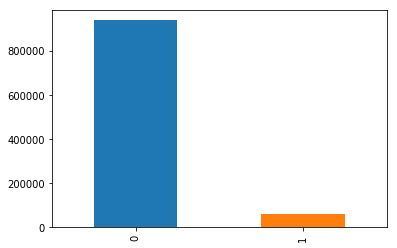

In [6]:
df.reverted.value_counts().plot.bar()

In [7]:
edits_year = df.time.apply(lambda x: x.year)
edits_month = df.time.apply(lambda x: x.month)
edits_day = df.time.apply(lambda x: x.day)

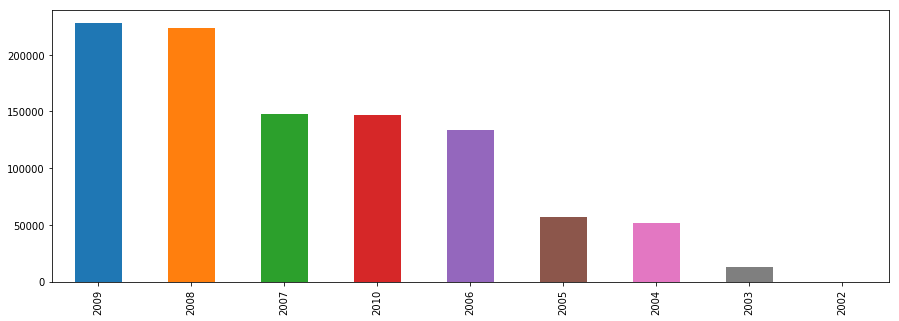

In [8]:
plt.figure(figsize=(15,5))
edits_year.value_counts().plot.bar()

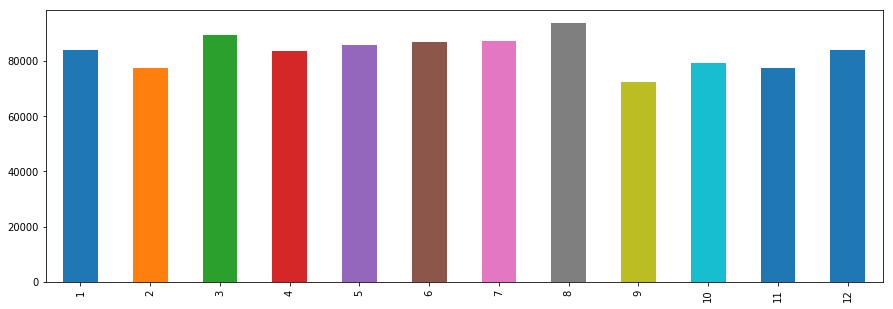

In [9]:
plt.figure(figsize=(15,5))
edits_month.value_counts().sort_index().plot.bar()

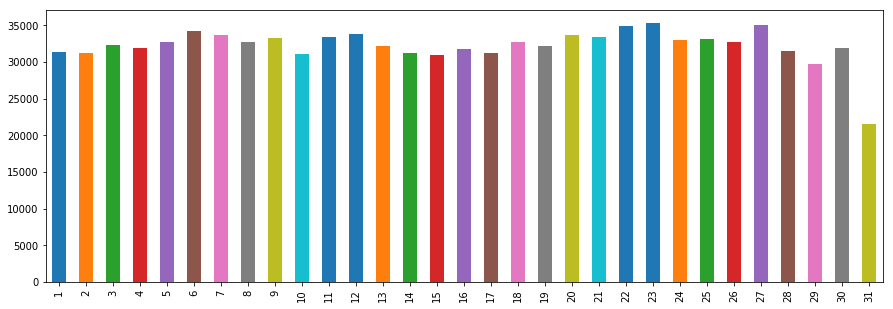

In [10]:
plt.figure(figsize=(15,5))
edits_day.value_counts().sort_index().plot.bar()

# Getting info from reverted updates

In [11]:
reverted = df[df.reverted==1]
reverted.head()

,user_id,article_id,revision_id,time,reverted
10,870433,1601117,30962488,2005-12-11 20:36:51,1
12,870433,241261,76627657,2006-09-19 18:26:11,1
42,870433,2816791,32225146,2005-12-21 11:19:58,1
43,870433,4599275,32003546,2005-12-19 20:14:33,1
45,870433,1681168,136024148,2007-06-05 09:54:21,1


In [12]:
first_revert = df[df.reverted==1].groupby(['user_id'])['time'].min()
first_revert = pd.DataFrame(first_revert)
first_revert.head(2)

,time
user_id,
799,2009-12-07 18:22:44
6787,2008-03-06 09:05:10


In [13]:
first_update = df.groupby(['user_id'])['time'].min()
first_update = pd.DataFrame(first_update)
first_update.head(2)

,time
user_id,
799,2009-10-25 15:55:18
2764,2007-04-26 01:00:13


In [14]:
revert_count = df[df.reverted==1].groupby(['user_id'])['time'].count()
revert_count = pd.DataFrame(revert_count)
revert_count = revert_count.rename(columns={'time': 'reverted_count'})
revert_count.head()

,reverted_count
user_id,
799,1
6787,2
12495,8
14140,2
18790,1


In [15]:
total_updates = df.groupby(['user_id'])['time'].count()
total_updates = pd.DataFrame(total_updates)
total_updates = total_updates.rename(columns={'time': 'total_updates'})
total_updates.head()

,total_updates
user_id,
799,54
2764,119
3002,1
3627,11
6526,3


In [16]:
df1 = pd.merge(df, first_revert, how='left', on='user_id', suffixes=('_update', '_first_revert'))
df1.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert
0,389427,9445560,279555872,2009-03-25 10:31:33,0,NaT
1,389427,9445560,279556938,2009-03-25 10:41:09,0,NaT


In [17]:
df2 = pd.merge(df1, first_update, how='left', on='user_id')
df2 = df2.rename(columns={'time': 'time_first_update'})
df2.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update
0,389427,9445560,279555872,2009-03-25 10:31:33,0,NaT,2005-06-03 17:05:34
1,389427,9445560,279556938,2009-03-25 10:41:09,0,NaT,2005-06-03 17:05:34


In [18]:
df3 = pd.merge(df2, revert_count, how='left', on='user_id')
df3.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update,reverted_count
0,389427,9445560,279555872,2009-03-25 10:31:33,0,NaT,2005-06-03 17:05:34,NaN
1,389427,9445560,279556938,2009-03-25 10:41:09,0,NaT,2005-06-03 17:05:34,NaN


In [19]:
df4 = pd.merge(df3, total_updates, how='left', on='user_id')
df4.head(2)

,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update,reverted_count,total_updates
0,389427,9445560,279555872,2009-03-25 10:31:33,0,NaT,2005-06-03 17:05:34,NaN,9
1,389427,9445560,279556938,2009-03-25 10:41:09,0,NaT,2005-06-03 17:05:34,NaN,9


# Correlation between days before first revert and number the updated after first revert?

In [20]:
# We only want users that had at least one update reverted
reverted_df = df4[df4.reverted_count >= 1]
reverted_df.shape

(990917, 9)

In [29]:
time_before_revert = reverted_df.time_first_revert - reverted_df.time_first_update
reverted_df['days_before_revert'] = time_before_revert.apply(lambda x: x.days)
reverted_df.head()

/Users/leportella/miniconda3/envs/wiki/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,article_id,revision_id,time_update,reverted,time_first_revert,time_first_update,reverted_count,total_updates,time_before_revert
9,870433,4205653,41325786,2006-02-26 16:25:02,0,2005-12-11 20:36:51,2005-01-27 12:15:26,65.0,678,318
10,870433,1601117,30962488,2005-12-11 20:36:51,1,2005-12-11 20:36:51,2005-01-27 12:15:26,65.0,678,318
11,870433,4207727,41356440,2006-02-26 20:48:38,0,2005-12-11 20:36:51,2005-01-27 12:15:26,65.0,678,318
12,870433,241261,76627657,2006-09-19 18:26:11,1,2005-12-11 20:36:51,2005-01-27 12:15:26,65.0,678,318
13,870433,9382502,106534410,2007-02-08 09:39:51,0,2005-12-11 20:36:51,2005-01-27 12:15:26,65.0,678,318


In [37]:
# And we want to check the updated that happened after the first revert
after_revert = reverted_df[reverted_df.time_update >= reverted_df.time_first_revert]
updates_after_revert = after_revert.groupby('user_id')['time_update'].count()

updates_after_revert = pd.DataFrame(updates_after_revert)
updates_after_revert = updates_after_revert.rename(columns={'time_update': 'updates_after_revert'})
updates_after_revert.head()

,updates_after_revert
user_id,
799,45
6787,24
12495,26
14140,53
18790,1


In [64]:
df = pd.merge(reverted_df, updates_after_revert, how='left', on='user_id')

Text(0.5, 1.0, 'Days before revert vs number of updates after revert')

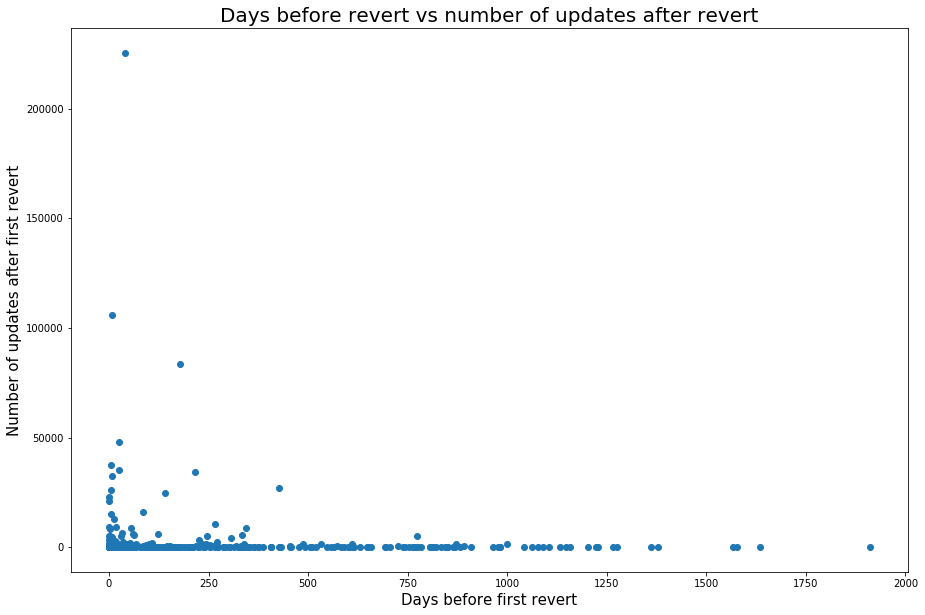

In [61]:
users_behavior = df.groupby('user_id').first()

plt.figure(figsize=(15,10))
plt.scatter(users_behavior.time_before_revert, users_behavior.updates_after_revert)
plt.xlabel('Days before first revert', fontsize=15)
plt.ylabel('Number of updates after first revert', fontsize=15)
plt.title('Days before revert vs number of updates after revert', fontsize=20)

# Analysis through time

In [85]:
from datetime import date 

df4['date'] = df4.time_update.apply(lambda x: x.date())
df4['date_monthly'] = df4.time_update.apply(lambda x: date(x.date().year, x.date().month, 1))

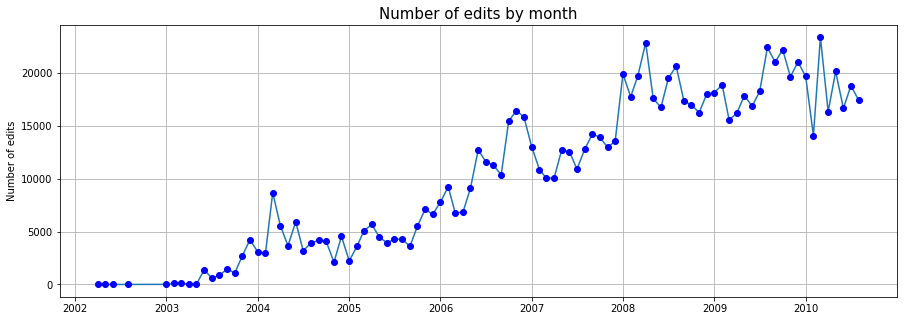

In [95]:
plt.figure(figsize=(15,5))
plt.plot(df4.date_monthly.value_counts().sort_index())
plt.plot(df4.date_monthly.value_counts().sort_index(), 'bo')
plt.ylabel('Number of edits')
plt.title('Number of edits by month', fontsize=15)
plt.grid()

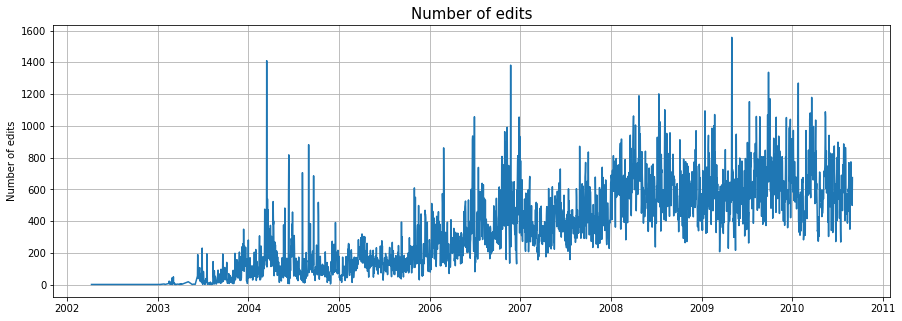

In [96]:
plt.figure(figsize=(15,5))
plt.plot(df4.date.value_counts().sort_index())
plt.ylabel('Number of edits')
plt.title('Number of edits', fontsize=15)
plt.grid()

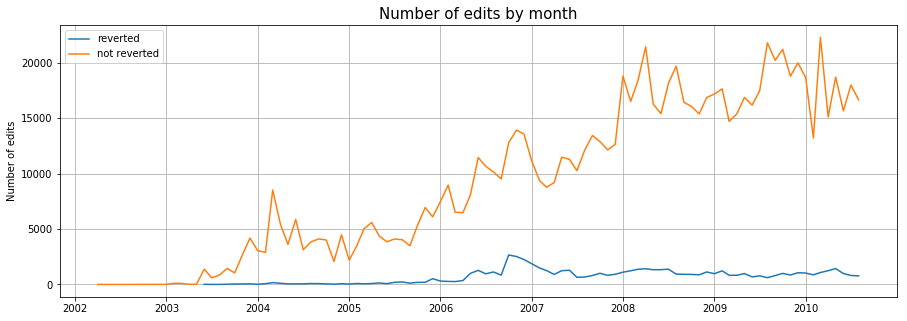

In [100]:
reverted = df4[df4.reverted==1]
not_reverted = df4[df4.reverted==0]

plt.figure(figsize=(15,5))
plt.plot(reverted.date_monthly.value_counts().sort_index())
plt.plot(not_reverted.date_monthly.value_counts().sort_index())
plt.legend(['reverted', 'not reverted'])
plt.ylabel('Number of edits')
plt.title('Number of edits by month', fontsize=15)
plt.grid()

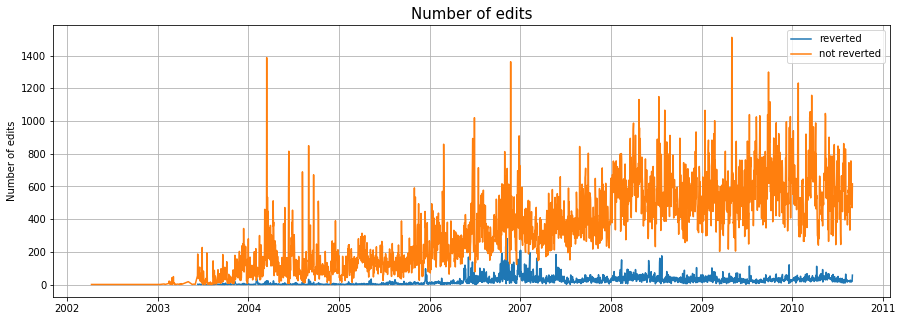

In [101]:
reverted = df4[df4.reverted==1]
not_reverted = df4[df4.reverted==0]

plt.figure(figsize=(15,5))
plt.plot(reverted.date.value_counts().sort_index())
plt.plot(not_reverted.date.value_counts().sort_index())
plt.legend(['reverted', 'not reverted'])
plt.ylabel('Number of edits')
plt.title('Number of edits', fontsize=15)
plt.grid()

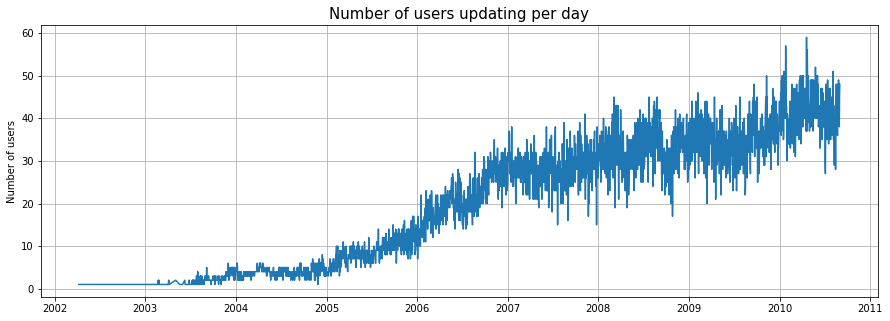

In [130]:
user_by_date = pd.crosstab(df4.date, df4.user_id)
user_by_date[user_by_date>1] = 1

user_by_date = user_by_date.sum(axis=1)

plt.figure(figsize=(15,5))
plt.plot(user_by_date)
plt.ylabel('Number of users')
plt.title('Number of users updating per day', fontsize=15)
plt.grid()

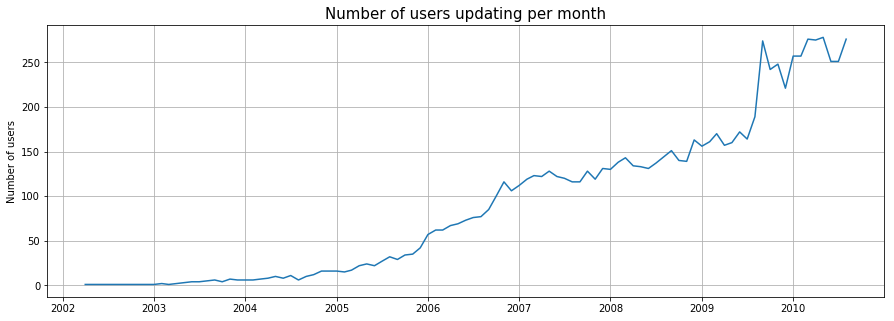

In [132]:
user_by_date = pd.crosstab(df4.date_monthly, df4.user_id)
user_by_date[user_by_date>1] = 1

user_by_date = user_by_date.sum(axis=1)

plt.figure(figsize=(15,5))
plt.plot(user_by_date)
plt.ylabel('Number of users')
plt.title('Number of users updating per month', fontsize=15)
plt.grid()